In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

import time
import math
import random
from tqdm import tqdm
import regex as re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Load in Always Pattern, Manual Review, and 20K Sample DF

In [2]:
always_patterns = pd.read_csv("Storage/Data/always_patterns.csv") 
always_patterns = always_patterns[['Unnamed: 0', 'patient_id', 'sequence','original', 'label']]
always_patterns.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
always_patterns.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,0,Z15564314,s other free text-see phs viewer social histor...,s other free text-see phs viewer Social Histor...,1
1,1,Z10171706,------- fusion: no sleep disturbance: no socia...,------- fusion: No Sleep disturbance: No Socia...,1
2,2,Z8935348,ain spasm). 30 tablet 0 unknown (outside pharm...,ain/spasm). 30 tablet 0 Unknown (outside pharm...,1
3,3,Z12212893,------- on 112mcg dose. maria will check dose ...,------- on 112mcg dose. Maria will check dos...,2
4,4,Z9598376,------- (vibramycin) 100 mg capsule take 1 cap...,------- (VIBRAMYCIN) 100 MG capsule Take 1 ca...,1


In [3]:
manual_review = pd.read_csv("Storage/Data/manual_review.csv")
manual_review = manual_review[['Unnamed: 0', 'patient_id', 'sequence','original', 'label']]
manual_review.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
manual_review.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,75,Z10504958,ndings: general: no apparent distress. surgica...,ndings: General: No apparent distress. Surgica...,0
1,77,Z6411816,"edness, no syncope, no dyspnea endocrine no po...","edness, No Syncope, No Dyspnea Endocrine No Po...",2
2,87,Z6813204,5 reps calibrated hand gripper with silver spr...,5 reps Calibrated hand gripper with silver sp...,0
3,95,Z10492528,nancial management services: none healthcare p...,nancial management Services: none Healthcare p...,0
4,106,Z7656517,2 | 1 time: 1 | 0 time: 0) 3. “are there any r...,2 | 1 time: 1 | 0 time: 0) 3. “Are there any r...,0


In [4]:
sample = pd.read_csv("Storage/Data/20K_sample.csv")
sample.columns = ['patient_id', 'sequence']
sample.head()

,patient_id,sequence
0,Z6450279,cystectomy due to his recurrent non- muscle in...
1,Z6450779,ghter continues on treatment for metastatic co...
2,Z6453461,6 neurosurgery attending: dr. cahill dr. anoop...
3,Z6453666,egative. neurological: negative. hematological...
4,Z6454616,"with an fi of 0.53, likely with diminished cog..."


## Splitting into Train, Validation, Split

In [113]:
X = always_patterns[["patient_id", "sequence"]]
y = always_patterns["annotator_label"]

y_label = y.to_numpy()
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,y,random_state=0,test_size=0.10, stratify=y_label)

y_test_valid_label = y_test_valid.to_numpy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=0, test_size=(0.25), stratify=y_test_valid_label)

In [114]:
X_2 = manual_review[["patient_id", "sequence"]]
y_2 = manual_review["annotator_label"]

y_label_2 = y_2.to_numpy()
X_train_2, X_test_valid_2, y_train_2, y_test_valid_2 = train_test_split(X_2,y_2,random_state=0,test_size=0.3, stratify=y_label_2)

y_test_valid_label_2 = y_test_valid_2.to_numpy()
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_test_valid_2, y_test_valid_2, random_state=0, test_size=(0.15/0.3), stratify=y_test_valid_label_2)

In [115]:
X_train = X_train.append(X_train_2)
y_train = y_train.append(y_train_2)

X_test = X_test.append(X_test_2)
y_test = y_test.append(y_test_2)

X_valid = X_valid.append(X_valid_2)
y_valid = y_valid.append(y_valid_2)

In [116]:
len(X_train), len(X_valid), len(X_test) 

(7669, 694, 293)

In [60]:
X_sample = sample['sequence']

## TF-IDF

In [61]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english",analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
tfidf_train= tfidf_vectorizer.fit_transform(X_train)
tfidf_valid = tfidf_vectorizer.transform(X_valid)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_sample = tfidf_vectorizer.transform(X_sample)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_train = pd.DataFrame(tfidf_train.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_valid = pd.DataFrame(tfidf_valid.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_sample = pd.DataFrame(tfidf_sample.A, columns = tfidf_vectorizer.get_feature_names())

tfidf_train.head()

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zurek,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.052614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
tfidf_train.shape, tfidf_valid.shape, tfidf_test.shape

((7669, 24098), (694, 24098), (293, 24098))

## Feature Selection

In [63]:
tfidf_train_features_df = pd.concat([tfidf_train, y_train.reset_index(drop=True)], axis=1)
tfidf_test_features_df = pd.concat([tfidf_test, y_test.reset_index(drop = True)], axis = 1)
tfidf_valid_features_df = pd.concat([tfidf_valid, y_valid.reset_index(drop = True)], axis = 1)

In [64]:
def filter_features_by_cor(df):
    m = len(df.columns)
    output = df.iloc[:,m-1] 
    output_list = output.tolist()
    corrcoef_array = []

    for i in range(0,m-2):
        input_list = df.iloc[:,i].tolist()
        cols = [input_list, output_list]
        corrcoef = abs(np.corrcoef(cols)) 
        corrcoef_array = np.append(corrcoef_array,corrcoef[0,1])

    feature_names = list(df)
    feature_names = feature_names[0:m-2]
    
    output_df = pd.DataFrame(feature_names, columns=['Features'])
    output_df['CorrCoef'] = corrcoef_array
    output_df = output_df.sort_values('CorrCoef')
    output_df = output_df.reset_index()
    output_df = output_df.drop(columns = "index")
    
    return output_df

In [65]:
tfidf_output_df = filter_features_by_cor(tfidf_train_features_df)
tfidf_output_df = tfidf_output_df.sort_values(by=['CorrCoef'],ascending = False)

In [66]:
tfidf_output_df.head(10)

,Features,CorrCoef
24096,intact,0.557335
24095,oriented,0.423366
24094,concentration,0.415752
24093,orientation,0.402930
24092,perceptions,0.395939
24091,sensorium,0.395415
24090,judgment,0.385164
24089,fund,0.373389
24088,experiences,0.369340
24087,ideation,0.361289


In [67]:
tfidf_train_features_df.drop(columns = 'annotator_label')
tfidf_test_features_df.drop(columns = 'annotator_label')
tfidf_valid_features_df.drop(columns = 'annotator_label')

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zurek,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.119656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Regularized Logistic Regression

In [68]:
def filter_by_corr(corr, tfidf_output_df):
    # Setting Correlation threshold
    top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
    filtered_tfidf_train = tfidf_train_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_valid = tfidf_valid_features_df.filter(items=top_tfidf_features_df['Features'])
    
    return top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid

In [69]:
def logisitic_regression(X_train, y_train, X_test, y_test, c, want_report, want_conf_mat, save_model, name):
    # fitting model
    lr = LogisticRegression(penalty='l1', solver='liblinear', C = c, random_state=0, class_weight = 'balanced')
    lr.fit(X_train, y_train)
    
    # predictions
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)

    # collecting results
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr')
    
    if (save_model == True):
        pickle.dump(lr, open("Storage/Model/" + name, 'wb'))
    
    if (want_report == True):
        target_names = ['NO', 'NTR', 'YES']
        results_lgr = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
        results_lgr = pd.DataFrame(results_lgr).transpose()
        
        if (want_conf_mat == True):
            return lr, acc, auc, c, results_lgr, confusion_matrix(y_test, y_pred)
    
        return lr, acc, auc, c, results_lgr
    
    if (want_conf_mat == True):
        return lr, acc, auc, c, confusion_matrix(y_test, y_pred)
        
    return lr, acc, auc, c

In [70]:
def cross_validation_split(dataset, n_folds):
    # ensuring straftification across label
    yes = cross_validation[cross_validation["annotator_label"] == 2].reset_index(drop = True)
    no = cross_validation[cross_validation["annotator_label"] == 0].reset_index(drop = True)
    ntr = cross_validation[cross_validation["annotator_label"] == 1].reset_index(drop = True)
    #print(len(yes), len(no), len(ntr))
    
    yes_count = len(yes) // n_folds
    no_count = len(no) // n_folds
    ntr_count = len(ntr) // n_folds
    #print(yes_count, no_count, ntr_count)
    split = list()
    fold_size = len(cross_validation) // n_folds

    # shuffling data to avoid having to generate random nums through while loop
    yes = yes.sample(frac=1).reset_index(drop=True)
    no = no.sample(frac=1).reset_index(drop=True)
    ntr = ntr.sample(frac=1).reset_index(drop=True)
    
    # creating folds
    for i in tqdm(range(n_folds)):
        fold = pd.DataFrame(columns = cross_validation.columns)

        fold = fold.append(yes[yes_count * i : (yes_count * i) + yes_count])
        #print(len(fold), "YES", )
        fold = fold.append(no[no_count * i : (no_count * i) + no_count])
        #print(len(fold), "NO", )
        fold = fold.append(ntr[ntr_count * i : (ntr_count * i) + ntr_count])
        #print(len(fold), "NTR", ((ntr_count * i) + ntr_count) - (ntr_count * i))
        split.append(fold)
        
    return split

In [71]:
def evaluate_algorithm(dataset, n_folds):
    splits = cross_validation_split(dataset, n_folds)
    
    counter = 0
    tfidf_all_df = pd.DataFrame()
    df_list  = []
    
    for fold in splits:
        train = splits.copy()
        del train[counter]
        train = pd.concat(train)
        
        y_train = train["annotator_label"].reset_index(drop = True)
        y_train = y_train.astype(int)
        
        y_test = fold["annotator_label"].reset_index(drop = True)
        y_test = y_test.astype(int)
        
        train = train.drop(columns = ["annotator_label"])
        fold = fold.drop(columns = ["annotator_label"])
        
        test = list()
        corr_list = list(np.arange(1,30) * 0.01)
       
        for corr in corr_list:
            acc_list = []
            auc_list = []
            c_list = []
             
            # filtering by correlation coefficient
            top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
            filtered_tfidf_train = train.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_fold = fold.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
            
            #print(filtered_tfidf_train.shape)
            #print(filtered_tfidf_fold.shape)
            
            # tuning for optimal lambda value
            for c in [0.01, 0.1, 1, 10, 100]:
                #name = "Fold-" + str((counter + 1)) + "-Corr-" + str(corr) + "-C-" + str(c) + ".sav"
                lr, acc, auc, c = logisitic_regression(filtered_tfidf_train, y_train, filtered_tfidf_fold, y_test, c, False, False, False, "")
                acc_list.append(acc)
                auc_list.append(auc)
                c_list.append(c)
            
            # gathering model stats
            acc_df = pd.DataFrame(acc_list, columns=['acc'])
            auc_df = pd.DataFrame(auc_list, columns=['auc'])
            c_df = pd.DataFrame(c_list, columns=['c_value'])
            
            assert len(acc_df) == len(auc_df) == len(c_df)
            
            #acc_df["fold_number"] = auc_df["fold_number"] = c_df["fold_number"] = [counter] * len(auc_df)
            
            iter_df = pd.concat([c_df, acc_df, auc_df], axis=1)
            iter_df['corr_thres'] = [corr] * len(iter_df)
            iter_df['fold_number'] = [(counter + 1)] * len(iter_df)
            df_list.append(iter_df)
            
        print("Completed Fold #: ", counter + 1)
        counter += 1
        
        print("Stats DF has", len(df_list), "records")
        
        #df_list.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Optimizing-data\sample_stat_df.csv", index = False)
    return df_list

In [72]:
cross_validation = pd.concat([tfidf_train_features_df, tfidf_valid_features_df])
tfidf_all_df = evaluate_algorithm(cross_validation, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


Completed Fold #:  1
Stats DF has 29 records
Completed Fold #:  2
Stats DF has 58 records
Completed Fold #:  3
Stats DF has 87 records
Completed Fold #:  4
Stats DF has 116 records
Completed Fold #:  5
Stats DF has 145 records
Completed Fold #:  6
Stats DF has 174 records
Completed Fold #:  7
Stats DF has 203 records
Completed Fold #:  8
Stats DF has 232 records
Completed Fold #:  9
Stats DF has 261 records
Completed Fold #:  10
Stats DF has 290 records


In [73]:
tfidf_all_df = pd.concat(tfidf_all_df)

In [74]:
corr_list = list(np.arange(1,30) * 0.01)
average_results_df = []

for corr in corr_list:
    for c in [0.01, 0.1, 1, 10, 100]:
        filtered = tfidf_all_df[(tfidf_all_df["corr_thres"] == corr) & (tfidf_all_df["c_value"] == c)]
        avg_auc = filtered["auc"].mean()
        avg_acc = filtered["acc"].mean()

        filler = np.arange(5, 9)**2
        df = pd.DataFrame(filler.reshape(1, 4), columns = ["c_value", "acc", "auc", "corr_thres"])
        df.loc[df.index] = [c, avg_acc, avg_auc, corr]
        #print(df)
        
        average_results_df.append(df)

In [75]:
average_results_df = pd.concat(average_results_df)

In [76]:
average_results_df[average_results_df['auc'] == max(average_results_df['auc'])]

,c_value,acc,auc,corr_thres
0,10.0,0.94067,0.988144,0.01


In [77]:
# Specific parameter setting performance
corr = 0.01
c = 10

y_train_cross_valid = cross_validation["annotator_label"]
y_test_cross_valid = tfidf_test_features_df["annotator_label"]

cross_validation.drop(columns = ["annotator_label"])
tfidf_test_features_df.drop(columns = ["annotator_label"])

# Setting Correlation threshold
top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
filtered_tfidf_train = cross_validation.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])

# Running model
lr, acc_optimized, auc_optimized, c_list, report, conf_mat = logisitic_regression(filtered_tfidf_train, y_train_cross_valid, filtered_tfidf_test, y_test_cross_valid, c, True, True, True, "model_test_optimal.sav")

print("\nC: ", c, "\n", report)
print("\nAUC: ", auc_optimized)
print("ACC: ", acc_optimized)
print("\nConfusion Matrix: \n", conf_mat)


C:  10 
               precision    recall  f1-score    support
NO             0.838384  0.798077  0.817734  104.00000
NTR            0.925373  0.879433  0.901818  141.00000
YES            0.650000  0.812500  0.722222   48.00000
accuracy       0.839590  0.839590  0.839590    0.83959
macro avg      0.804586  0.830003  0.813925  293.00000
weighted avg   0.849384  0.839590  0.842551  293.00000

AUC:  0.9454993869092255
ACC:  0.8395904436860068

Confusion Matrix: 
 [[ 83   7  14]
 [ 10 124   7]
 [  6   3  39]]


In [136]:
FP = conf_mat.sum(axis = 0) - np.diag(conf_mat) 
FN = conf_mat.sum(axis = 1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

Sensitivity:  [0.79807692 0.87943262 0.8125    ]
Specificity:  [0.91534392 0.93421053 0.91428571]
NPV:  [0.89175258 0.89308176 0.96137339]
PPV:  [0.83838384 0.92537313 0.65      ]


## Saving 

In [117]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
train = pd.concat([X_train, y_train], axis = 1)

In [118]:
X_valid = X_valid.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
valid = pd.concat([X_valid, y_valid], axis = 1)

In [119]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
test = pd.concat([X_test, y_test], axis = 1)

In [120]:
train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\train_8_11.csv", index = False)
valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\valid_8_11.csv", index = False)
test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\test_8_11.csv", index = False)

In [121]:
pickle.dump(lr, open("Storage/" + "model_8_11.sav", 'wb'))

## Getting Test Set Probabilties

In [122]:
model = pickle.load(open(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\model_8_11.sav", 'rb'))

In [123]:
test = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\data\test_8_11.csv")

In [124]:
test_predictions = model.predict(tfidf_test.filter(items=top_tfidf_features_df['Features']))

In [125]:
test["predictions"] = test_predictions

In [126]:
test_proba = model.predict_proba(tfidf_test.filter(items = top_tfidf_features_df['Features']))

In [127]:
test_proba = np.array([[x] for x in np.max(test_proba, axis=1)])

In [128]:
test_proba = [item for sublist in test_proba for item in sublist]

In [129]:
test["probability"] = test_proba

In [130]:
test

,patient_id,sequence,annotator_label,predictions,probability
0,Z9096104,ital status: married civil union spouse name: ...,1,1,0.995352
1,Z7410349,history narrative social history tobacco quit ...,1,1,0.993789
2,Z7754903,ncy-based suicidal statements. suicidal homici...,0,0,0.996983
3,Z11959548,js; bjshingleton li61ao +21.5d target plano • ...,1,1,0.997076
4,Z7580275,rts pedal edema is worsened recently. current ...,2,2,0.968128
...,...,...,...,...,...
288,Z7055023,rmin 2000 mg daily - loose stools every 4-5 da...,0,2,0.981335
289,Z9328738,rmittently with tenderness to palpation in shi...,0,0,0.714377
290,Z9191149,"r in jamaica plain, or his aunt in roxbury. he...",0,2,0.814742
291,Z9076719,15) weight: 68.9 kg (151 lb 12.8 oz) (07 22 19...,0,1,0.551733


In [131]:
test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Baseline_Model\data\probabilities_test_set.csv", index = False)

## Running on 20K Samples

In [143]:
sample_predictions = model.predict(tfidf_sample.filter(items = top_tfidf_features_df['Features']))

In [148]:
sample["predictions"] = sample_predictions

In [150]:
sample

,patient_id,sequence,prediction
0,Z6450279,cystectomy due to his recurrent non- muscle in...,2
1,Z6450779,ghter continues on treatment for metastatic co...,2
2,Z6453461,6 neurosurgery attending: dr. cahill dr. anoop...,0
3,Z6453666,egative. neurological: negative. hematological...,0
4,Z6454616,"with an fi of 0.53, likely with diminished cog...",0
...,...,...,...
19995,Z8017342,e - yawkey building 617-724-2142 condition lis...,0
19996,Z10340229,ualized aortic diameter was 2.6 cm 20. seconda...,1
19997,Z13736634,iety about health intracranial tumor secondary...,0
19998,Z15658673,"rt and oriented to person, place and time. ski...",0


In [151]:
bib1 = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\sd587_03212118253982866_6375194824947826181_Bib.csv")
bib2 = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\sd587_03212118253982866_6375194824947826182_Bib.csv")
nodup = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\Partners_biobank_APOE_nodup.csv")

In [152]:
bib = pd.concat([bib1, bib2])

In [153]:
bib = bib.reset_index(drop = True)
nodup = nodup.reset_index(drop = True)

In [154]:
apoe = []
for i in tqdm(range(len(bib))):
    allele = str((nodup[nodup["subject_id"] == bib.loc[i]["Subject_Id"]]["APOE"].values))
    allele = allele[2:len(allele)-2]
    apoe.append(allele)

100%|███████████████████████████████████████████████████████████████████████████| 37793/37793 [01:09<00:00, 541.08it/s]


In [155]:
bib["APOE"] = apoe

In [156]:
apoe = []
for i in range(len(sample)):
    allele = bib[bib["EMPI"] == bib.loc[i]["EMPI"]]["APOE"].values
    apoe.append(allele)

In [157]:
sample["apoe"] = apoe

In [158]:
convert = {2 : "YES", 1 : "NTR", 0: "NO"}

In [164]:
sample.prediction = [convert[i] for i in sample.prediction]

In [165]:
y = sample[sample["prediction"] == "YES"]
ntr = sample[sample["prediction"] == "NTR"]
n = sample[sample["prediction"] == "NO"]

In [166]:
y["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             3675
[e3/e4]             1236
[e2/e3]              715
[e4/e4]              142
[e2/e4 or e1/e3]     126
[]                    41
[e2/e2]               32
Name: apoe, dtype: int64

In [167]:
n["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             7346
[e3/e4]             2384
[e2/e3]             1388
[e2/e4 or e1/e3]     251
[e4/e4]              248
[]                    70
[e2/e2]               61
Name: apoe, dtype: int64

In [168]:
ntr["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             1415
[e3/e4]              496
[e2/e3]              260
[e2/e4 or e1/e3]      51
[e4/e4]               44
[]                    11
[e2/e2]                8
Name: apoe, dtype: int64

In [169]:
sample["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             12436
[e3/e4]              4116
[e2/e3]              2363
[e4/e4]               434
[e2/e4 or e1/e3]      428
[]                    122
[e2/e2]               101
Name: apoe, dtype: int64

In [171]:
sample.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\20K_sample_8_11.csv", index = False)

## ROC-Curve

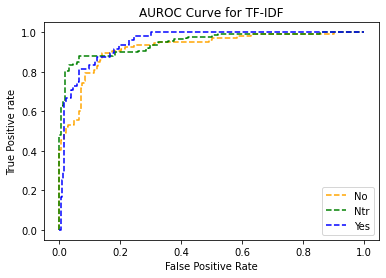

In [189]:
n_class = 3

pred_prob = model.predict_proba(filtered_tfidf_test)

fpr = {}
tpr = {}
thresh ={}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label = i)

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='No')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Ntr')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Yes')
plt.title('AUROC Curve for TF-IDF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUROC Curve for TF-IDF', dpi = 300)